In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm import tqdm
import scipy.io

%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [55]:
def apply_gamma(image, gamma):
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    
    r_ = 255 * (r/255)**gamma
    g_ = 255 * (g/255)**gamma
    b_ = 255 * (b/255)**gamma
    
    image_adjusted = np.dstack((r_,g_,b_))
    return image_adjusted.astype(int)

#### Light Sources

In [2]:
#CIE Illuminants A and D65
df_A = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [0,1], names = ["wavelength", "illumination"])
df_D65 = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [6,7], names = ["wavelength", "illumination"])

#CIE Fluorescent lamps
df_fluorescent = pd.read_excel("Fluorescents.xls", skiprows = 1)
df_fluorescent.rename(columns={'Unnamed: 0':'wavelength'}, inplace=True)

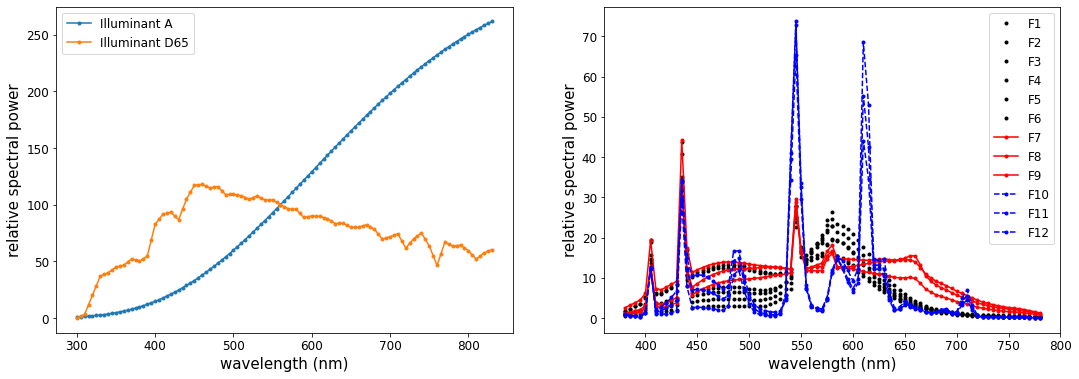

In [3]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(df_A.wavelength, df_A.illumination, '.-', label = "Illuminant A")
plt.plot(df_D65.wavelength, df_D65.illumination, '.-', label = "Illuminant D65")
plt.xlabel("wavelength (nm)", fontsize = 15)
plt.ylabel("relative spectral power", fontsize = 15)
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
for i in df_fluorescent.columns.values.tolist()[1:]:
    if i in ["F1", "F2", "F3", "F4", "F5", "F6"]: #Common Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.', color = "black",  label = i)
    if i in ["F7", "F8", "F9"]: # High Color Rendering Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.-', color = "red",  label = i)
    if i in ["F10", "F11", "F12"]: #Three Band Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.--', color = "blue",  label = i)

plt.xlabel("wavelength (nm)", fontsize = 15)
plt.ylabel("relative spectral power", fontsize = 15)
plt.legend(fontsize = 12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("light_sources.png", dpi = 200, bbox_inches = "tight")
plt.show()

In [4]:
df_macbeth = pd.read_excel("MacbethColorChecker.xls", skiprows = 2, usecols = np.arange(0,25))

In [5]:
# #Reflectance - Macbeth Color Checker
# for i in df_macbeth.columns[1:]:
#     df_macbeth[i] = df_macbeth[i]/(0.891)
# df_macbeth.head()

In [7]:
# for i in df_macbeth.columns[1:]:
#     plt.plot(df_macbeth.wavelength, df_macbeth[i]/(df_macbeth[np.arange(1,25)].max().max()))
# plt.show()

#### Camera

In [8]:
#Camera Sensitivity
df_sony = pd.read_excel("Sony_Dxc_930.xlsx").iloc[:, 0].str.split(' ', expand=True)
df_sony.rename(columns={0:'wavelength', 1: 'red', 2: 'green', 3: 'blue'}, inplace=True)
df_sony = df_sony.apply(pd.to_numeric)

df_kodak = pd.read_excel("Kodak_Dcs_420.xlsx").iloc[:, 0].str.split(' ', expand=True)
df_kodak.rename(columns={0:'wavelength', 1: 'red', 2: 'green', 3: 'blue'}, inplace=True)
df_kodak = df_kodak.apply(pd.to_numeric)

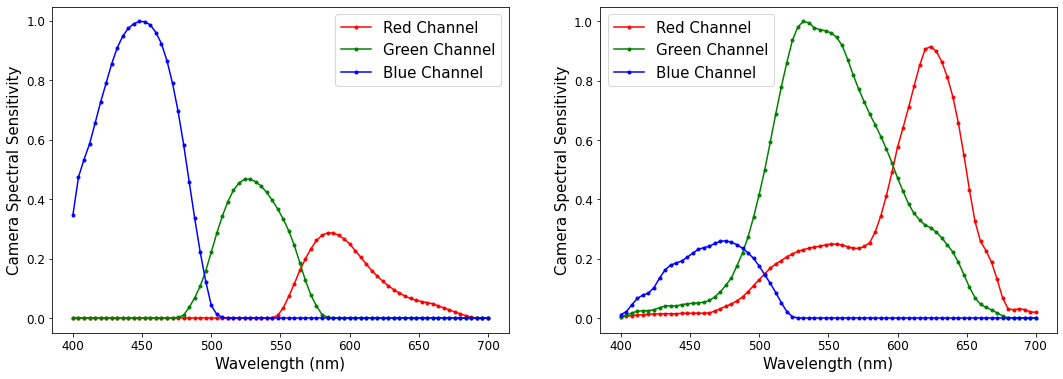

In [9]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(df_sony.wavelength, df_sony.red, '.-', color = 'red', label = 'Red Channel')
plt.plot(df_sony.wavelength, df_sony.green, '.-', color = 'green', label = 'Green Channel')
plt.plot(df_sony.wavelength, df_sony.blue, '.-', color = 'blue', label = 'Blue Channel')
#plt.plot(df_D65.wavelength, df_D65.illumination/df_D65.illumination.max(), '.-', label = "Kodak DCS-420")
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Camera Spectral Sensitivity", fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
plt.plot(df_kodak.wavelength, df_kodak.red, '.-', color = 'red', label = 'Red Channel')
plt.plot(df_kodak.wavelength, df_kodak.green, '.-', color = 'green', label = 'Green Channel')
plt.plot(df_kodak.wavelength, df_kodak.blue, '.-', color = 'blue', label = 'Blue Channel')
#plt.plot(df_D65.wavelength, df_D65.illumination/df_D65.illumination.max(), '.-', label = "Kodak DCS-420")
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Camera Spectral Sensitivity", fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("Camera.png", bbox_inches = "tight", dpi = 200)
plt.show()

In [10]:
def color_output(wavelength, P, R, Sr, Sg, Sb): 
    """
    Input:
    P - light source spectral power distribution
    R - reflectance of the object
    S - camera spectral sensitivity (red, green, and blue channels)
    
    Output:
    C - camera output [R,G,B]
    """
    
    Cr = sum(P * R * Sr) / sum(P * Sr)
    Cg = sum(P * R * Sg) / sum(P * Sg)
    Cb = sum(P * R * Sb) / sum(P * Sb)
    
    C = [Cr, Cg, Cb]
    
    return C

def visualize_color(intensity, color):
    output = np.zeros([10,10,3])
    output[:,:,0] = int(color[0]*intensity)
    output[:,:,1] = int(color[1]*intensity)
    output[:,:,2] = int(color[2]*intensity)
    output = output.astype(int)
    
    plt.imshow(output)
    plt.axis('off')
    plt.title('RGB: (' + str(int(color[0]*intensity)) + ',' + str(int(color[1]*intensity)) + ',' + str(int(color[2]*intensity)) + ')', fontsize=15)
    plt.show()

In [23]:
def recreate_image(df_camera, df_object, df_light_source, intensity, camera_name, light_name):
    '''
    df_camera should have columns with names 'wavelength', 'red', 'green', and 'blue'
    df_object should have columns with names 'wavelength', and reflectance values
    df_light_source should have columns with 'wavelength' and 'illumination'
    title is the name of the object
    '''
    N = 24 #number of macbeth colors
    macbeth = np.zeros([N,N,3])
    colors = []
    
    for i in [i for i in df_object.columns][1:]:
        wavelength = np.copy(df_object.wavelength)
        light_source = np.interp(wavelength, df_light_source.wavelength, df_light_source.illumination)
        camera_red = np.interp(wavelength, df_camera.wavelength, df_camera.red)
        camera_green = np.interp(wavelength, df_camera.wavelength, df_camera.green)
        camera_blue = np.interp(wavelength, df_camera.wavelength, df_camera.blue)

        color = color_output(wavelength, light_source, df_object[i], camera_red, camera_green, camera_blue)
        colors.append(color)
    
    colors = np.array(colors)
    colors_df = pd.DataFrame(colors, columns = ['red', 'green', 'blue'])
    colors_df_tosave = colors_df.copy()
    colors_df_tosave['red'] = colors_df_tosave['red'] * sum(light_source * camera_red)
    colors_df_tosave['green'] = colors_df_tosave['green'] * sum(light_source * camera_green)
    colors_df_tosave['blue'] = colors_df_tosave['blue'] * sum(light_source * camera_blue)
    colors_df_tosave.to_csv('macbeth_'+str(camera_name)+'_'+str(light_name)+'_'+'.csv', index = 'false')
    
    macbeth[:,:,0] = colors[:,0] * intensity
    macbeth[:,:,1] = colors[:,1] * intensity
    macbeth[:,:,2] = colors[:,2] * intensity

    macbeth = macbeth.astype(int)

    array1 = np.array([macbeth[0][0:6]])
    array2 = np.array([macbeth[0][6:12]])
    array3 = np.array([macbeth[0][12:18]])
    array4 = np.array([macbeth[0][18:24]])

    array_camera = np.vstack((array1,array2, array3, array4))
    #print(array_camera.max())
    array_camera[array_camera > 255] = 255
        
    return array_camera

In [35]:
def recreate_macbeth(array):
    #plt.figure(figsize=[9,6])
    plt.imshow(array)
    for i in range(5):
        plt.axhline(y=-0.5+i, color='black', linewidth = 5)
    for j in range(7):
        plt.axvline(x=-0.5+j, color='black', linewidth = 5)

    plt.axhline(y=-0.5, color='black', linewidth = 10)
    plt.axhline(y=3.5, color='black', linewidth = 10)
    plt.axvline(x=-0.5, color='black', linewidth = 10)
    plt.axvline(x=5.5, color='black', linewidth = 10)
    plt.axis('off')

In [36]:
df_fluorescentF1 = df_fluorescent[['wavelength', 'F1']]
df_fluorescentF1.rename(columns = {'F1':'illumination'}, inplace = True)

df_fluorescentF7 = df_fluorescent[['wavelength', 'F7']]
df_fluorescentF7.rename(columns = {'F7':'illumination'}, inplace = True)

df_fluorescentF10 = df_fluorescent[['wavelength', 'F10']]
df_fluorescentF10.rename(columns = {'F10':'illumination'}, inplace = True)

In [37]:
light_source_names  = ['A', 'D65', 'F1', 'F7', 'F10']
camera_names = ['SonyDXC-930', 'KodakDCS-420']
camera_used = [df_sony, df_kodak]
light_used = [df_A, df_D65, df_fluorescentF1,  df_fluorescentF1,  df_fluorescentF7]

camera_light_names = [(r[0], r[1]) for r in itertools.product(camera_names, light_source_names)]

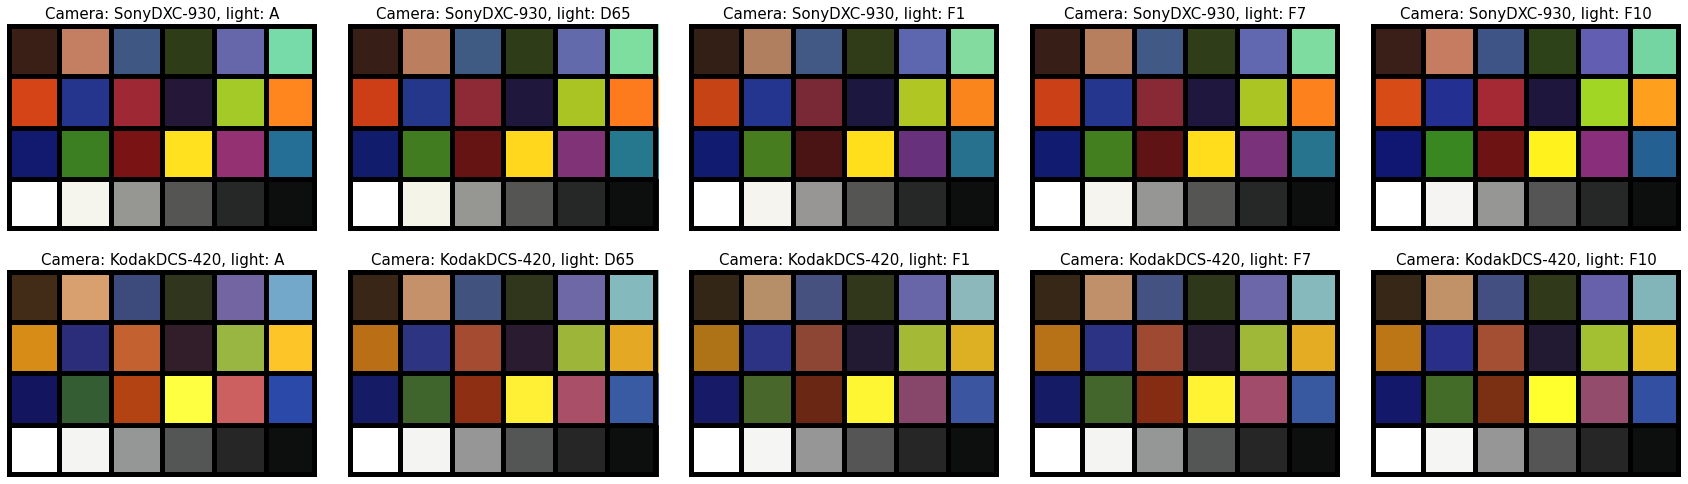

In [64]:
intensity = 420

plt.figure(figsize = (6*5,6*1.5))
for i, names in enumerate(camera_light_names):
    if names[0] == 'SonyDXC-930': df_camera = df_sony.copy()
    if names[0] == 'KodakDCS-420': df_camera = df_kodak.copy()
    if names[1] == 'A': df_light_source = df_A.copy()
    if names[1] == 'D65': df_light_source = df_D65.copy()
    if names[1] == 'F1': df_light_source = df_fluorescentF1.copy()
    if names[1] == 'F7': df_light_source = df_fluorescentF7.copy()
    if names[1] == 'F10': df_light_source = df_fluorescentF10.copy()
    
    array_macbeth = recreate_image(df_camera, df_macbeth, df_light_source, intensity, names[0], names[1])
    plt.subplot(2,5,i+1)
    recreate_macbeth(array_macbeth)
    plt.title("Camera: "+str(names[0])+ ", light: "+str(names[1]), fontsize = 15)

plt.subplots_adjust(wspace=0.1, hspace=0.01)
plt.savefig('rendered_macbeth_bright.png', bbox_inches = 'tight', dpi = 300)
plt.show()

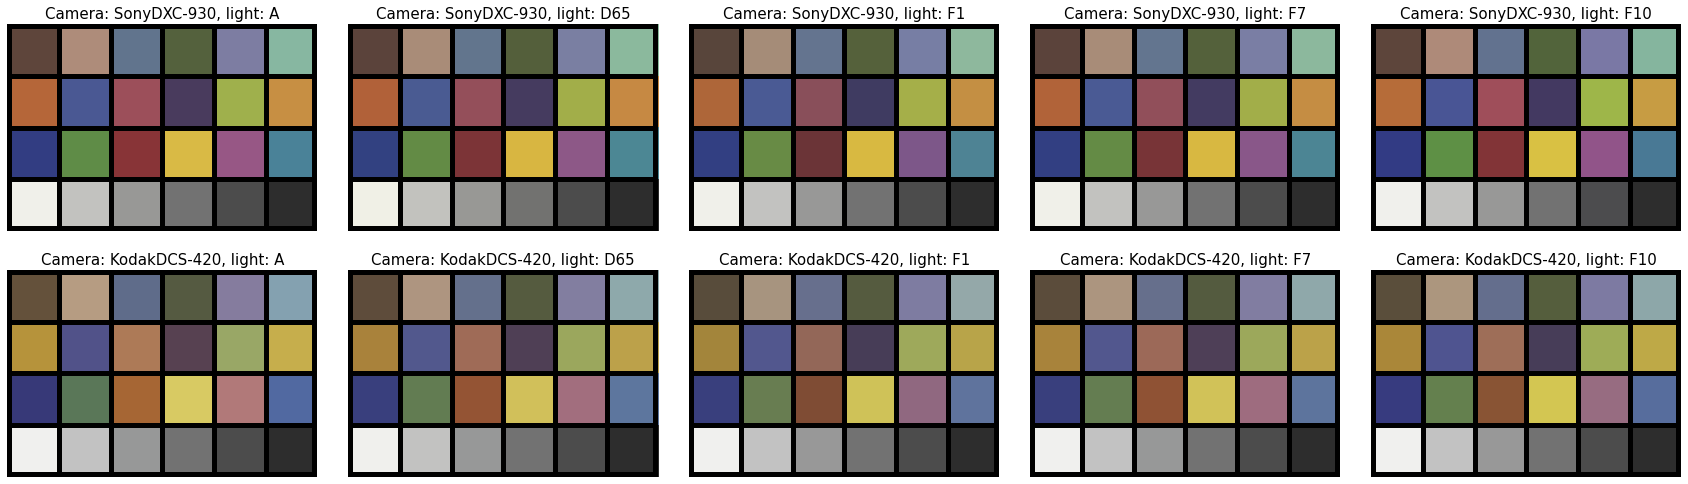

In [63]:
intensity = 255

plt.figure(figsize = (6*5,6*1.5))
for i, names in enumerate(camera_light_names):
    if names[0] == 'SonyDXC-930': df_camera = df_sony.copy()
    if names[0] == 'KodakDCS-420': df_camera = df_kodak.copy()
    if names[1] == 'A': df_light_source = df_A.copy()
    if names[1] == 'D65': df_light_source = df_D65.copy()
    if names[1] == 'F1': df_light_source = df_fluorescentF1.copy()
    if names[1] == 'F7': df_light_source = df_fluorescentF7.copy()
    if names[1] == 'F10': df_light_source = df_fluorescentF10.copy()
    
    array_macbeth = recreate_image(df_camera, df_macbeth, df_light_source, intensity, names[0], names[1])
    plt.subplot(2,5,i+1)
    recreate_macbeth(apply_gamma(array_macbeth, gamma = 0.5))
    plt.title("Camera: "+str(names[0])+ ", light: "+str(names[1]), fontsize = 15)

plt.subplots_adjust(wspace=0.1, hspace=0.01)
plt.savefig('rendered_macbeth_gamma_corrected.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [65]:
scene5 = scipy.io.loadmat('scene5.mat')
scene8 = scipy.io.loadmat('scene8.mat')

reflectance_scene5 = scene5['reflectances']
reflectance_scene8 = scene8['reflectances']

In [66]:
#reflectance_scene5 = reflectance_scene5 / reflectance_scene5.max()
#reflectance_scene8 = reflectance_scene8 / reflectance_scene8.max()

In [67]:
def recreate_scene(df_camera, df_object, df_light_source, intensity, scene_name, camera_name, light_name):
    '''
    df_camera should have columns with names 'wavelength', 'red', 'green', and 'blue'
    df_light_source should have columns with 'wavelength' and 'illumination'
    title is the name of the object
    '''
    shape = df_object.shape
    recreated_image_R = np.zeros([shape[0], shape[1]])
    recreated_image_G = np.zeros([shape[0], shape[1]])
    recreated_image_B = np.zeros([shape[0], shape[1]])
    
    for i in tqdm(range(shape[0])):
        for j in range(shape[1]):
            wavelength = np.arange(410, 710 + 10, 10)
            light_source = np.interp(wavelength, df_light_source.wavelength, df_light_source.illumination)
            camera_red = np.interp(wavelength, df_camera.wavelength, df_camera.red)
            camera_green = np.interp(wavelength, df_camera.wavelength, df_camera.green)
            camera_blue = np.interp(wavelength, df_camera.wavelength, df_camera.blue)
            
            recreated_image_R[i][j], recreated_image_G[i][j], recreated_image_B[i][j] = color_output(wavelength, light_source, df_object[i][j], camera_red, camera_green, camera_blue)
    
    recreated_image = np.dstack((recreated_image_R,recreated_image_G,recreated_image_B))
    #recreated_image.to_csv(str(scence_name)+'_'+str(camera_name)+'_'+str(light_name)+'_'+'.csv', index = 'false')
        
    return recreated_image

In [68]:
image_scene5_sony_A = recreate_scene(df_sony, reflectance_scene5, df_A, intensity, 'scene5', 'SonyDXC-930', 'A')
image_scene5_sony_D65 = recreate_scene(df_sony, reflectance_scene5, df_D65, intensity, 'scene5', 'SonyDXC-930', 'D65')
image_scene5_sony_F1 = recreate_scene(df_sony, reflectance_scene5, df_fluorescentF1, intensity, 'scene5', 'SonyDXC-930', 'F1')
image_scene5_sony_F7 = recreate_scene(df_sony, reflectance_scene5, df_fluorescentF7, intensity, 'scene5', 'SonyDXC-930', 'F7')
image_scene5_sony_F10 = recreate_scene(df_sony, reflectance_scene5, df_fluorescentF10, intensity, 'scene5', 'SonyDXC-930', 'F10')

100%|██████████| 819/819 [01:20<00:00, 10.18it/s]


In [101]:
image_scene5_kodak_A = recreate_scene(df_kodak, reflectance_scene5, df_A, intensity, 'scene5', 'KodakDCS-420', 'A')
image_scene5_kodak_D65 = recreate_scene(df_kodak, reflectance_scene5, df_D65, intensity, 'scene5', 'KodakDCS-420', 'D65')
image_scene5_kodak_F1 = recreate_scene(df_kodak, reflectance_scene5, df_fluorescentF1, intensity, 'scene5', 'KodakDCS-420', 'F1')
image_scene5_kodak_F7 = recreate_scene(df_kodak, reflectance_scene5, df_fluorescentF7, intensity, 'scene5', 'KodakDCS-420', 'F7')
image_scene5_kodak_F10 = recreate_scene(df_kodak, reflectance_scene5, df_fluorescentF10, intensity, 'scene5', 'KodakDCS-420', 'F10')

100%|██████████| 819/819 [01:27<00:00,  9.37it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

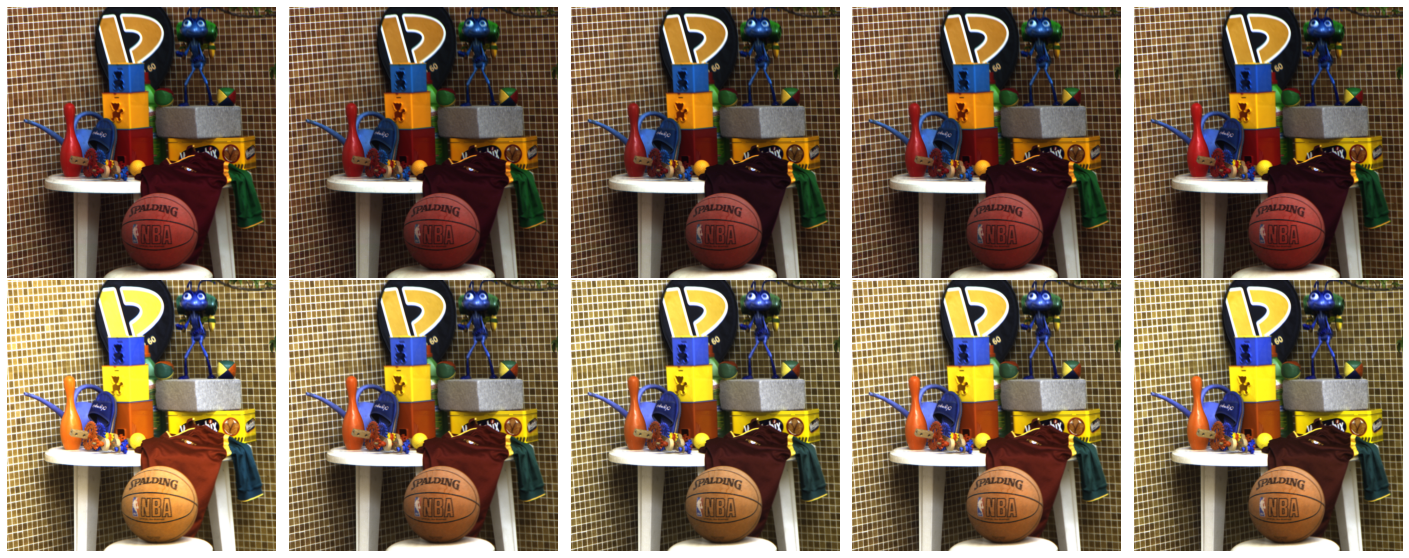

In [107]:
plt.figure(figsize = (25, 10))
intensity = 255 * 4

plt.subplot(251)
plt.imshow(((image_scene5_sony_A / image_scene5_sony_A.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(252)
plt.imshow(((image_scene5_sony_D65 / image_scene5_sony_D65.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(253)
plt.imshow(((image_scene5_sony_F1 / image_scene5_sony_F1.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(254)
plt.imshow(((image_scene5_sony_F7 / image_scene5_sony_F7.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(255)
plt.imshow(((image_scene5_sony_F10 / image_scene5_sony_F10.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(256)
plt.imshow(((image_scene5_kodak_A / image_scene5_kodak_A.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(257)
plt.imshow(((image_scene5_kodak_D65 / image_scene5_kodak_D65.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(258)
plt.imshow(((image_scene5_kodak_F1 / image_scene5_kodak_F1.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(259)
plt.imshow(((image_scene5_kodak_F7 / image_scene5_kodak_F7.max()) * intensity).astype(int))
plt.axis('off')

plt.subplot(2,5,10)
plt.imshow(((image_scene5_kodak_F10 / image_scene5_kodak_F10.max()) * intensity).astype(int))
plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.01)

plt.savefig('recreated_scene5.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [108]:
image_scene8_sony_A = recreate_scene(df_sony, reflectance_scene8, df_A, intensity, 'scene8', 'SonyDXC-930', 'A')
image_scene8_sony_D65 = recreate_scene(df_sony, reflectance_scene8, df_D65, intensity, 'scene8', 'SonyDXC-930', 'D65')
image_scene8_sony_F1 = recreate_scene(df_sony, reflectance_scene8, df_fluorescentF1, intensity, 'scene8', 'SonyDXC-930', 'F1')
image_scene8_sony_F7 = recreate_scene(df_sony, reflectance_scene8, df_fluorescentF7, intensity, 'scene8', 'SonyDXC-930', 'F7')
image_scene8_sony_F10 = recreate_scene(df_sony, reflectance_scene8, df_fluorescentF10, intensity, 'scene8', 'SonyDXC-930', 'F10')

image_scene8_kodak_A = recreate_scene(df_kodak, reflectance_scene8, df_A, intensity, 'scene8', 'KodakDCS-420', 'A')
image_scene8_kodak_D65 = recreate_scene(df_kodak, reflectance_scene8, df_D65, intensity, 'scene8', 'KodakDCS-420', 'D65')
image_scene8_kodak_F1 = recreate_scene(df_kodak, reflectance_scene8, df_fluorescentF1, intensity, 'scene8', 'KodakDCS-420', 'F1')
image_scene8_kodak_F7 = recreate_scene(df_kodak, reflectance_scene8, df_fluorescentF7, intensity, 'scene8', 'KodakDCS-420', 'F7')
image_scene8_kodak_F10 = recreate_scene(df_kodak, reflectance_scene8, df_fluorescentF10, intensity, 'scene8', 'KodakDCS-420', 'F10')

100%|██████████| 700/700 [01:03<00:00, 10.97it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 607.5, 699.5, -0.5)

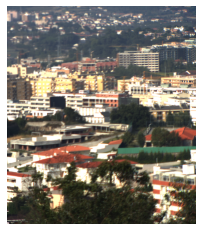

In [110]:
plt.imshow(image_scene8_sony_A)
plt.axis('off')

In [115]:
image = image_scene8_sony_A
image = image / image.max()
image = (image * 255).astype(int)
image.max()

255

(-0.5, 607.5, 699.5, -0.5)

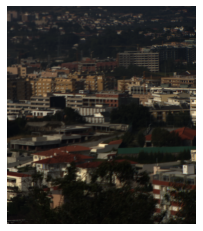

In [117]:
plt.imshow(image)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

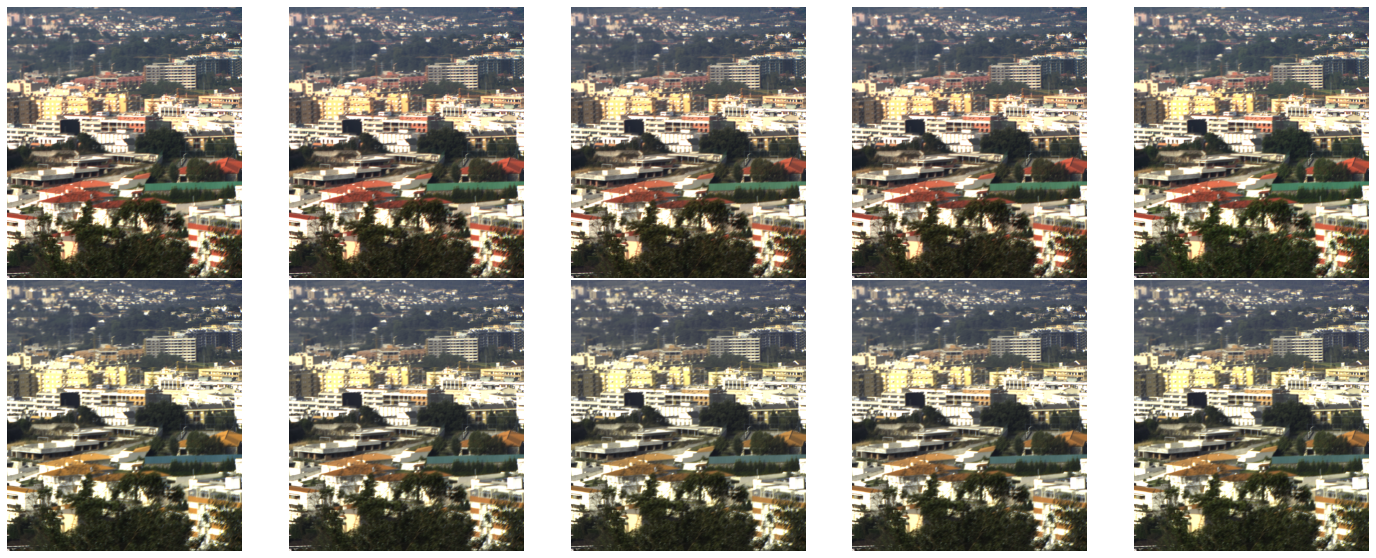

In [109]:
plt.figure(figsize = (25, 10))

plt.subplot(251)
plt.imshow(image_scene8_sony_A)
plt.axis('off')

plt.subplot(252)
plt.imshow(image_scene8_sony_D65)
plt.axis('off')

plt.subplot(253)
plt.imshow(image_scene8_sony_F1)
plt.axis('off')

plt.subplot(254)
plt.imshow(image_scene8_sony_F7)
plt.axis('off')

plt.subplot(255)
plt.imshow(image_scene8_sony_F10)
plt.axis('off')

plt.subplot(256)
plt.imshow(image_scene8_kodak_A)
plt.axis('off')

plt.subplot(257)
plt.imshow(image_scene8_kodak_D65)
plt.axis('off')

plt.subplot(258)
plt.imshow(image_scene8_kodak_F1)
plt.axis('off')

plt.subplot(259)
plt.imshow(image_scene8_kodak_F7)
plt.axis('off')

plt.subplot(2,5,10)
plt.imshow(image_scene8_kodak_F10)
plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.01)

plt.savefig('recreated_scene8.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

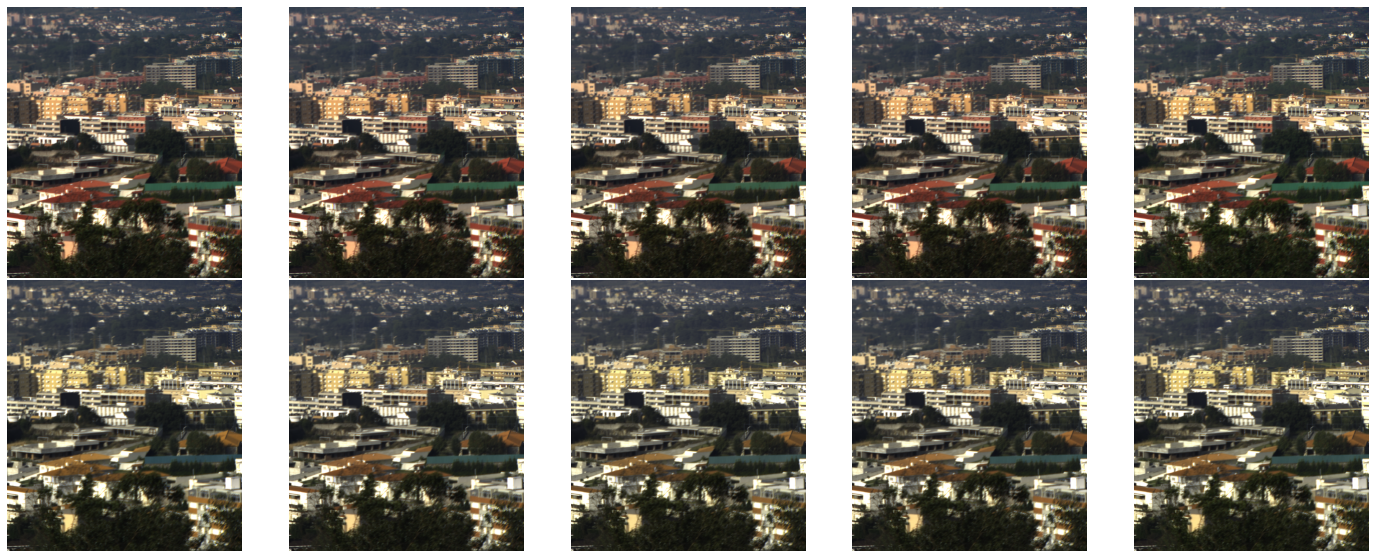

In [121]:
plt.figure(figsize = (25, 10))
intensity = 255 * 2

plt.subplot(251)
plt.imshow(((image_scene8_sony_A / image_scene8_sony_A.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(252)
plt.imshow(((image_scene8_sony_D65 / image_scene8_sony_D65.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(253)
plt.imshow(((image_scene8_sony_F1 / image_scene8_sony_F1.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(254)
plt.imshow(((image_scene8_sony_F7 / image_scene8_sony_F7.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(255)
plt.imshow(((image_scene8_sony_F10 / image_scene8_sony_F10.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(256)
plt.imshow(((image_scene8_kodak_A / image_scene8_kodak_A.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(257)
plt.imshow(((image_scene8_kodak_D65 / image_scene8_kodak_D65.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(258)
plt.imshow(((image_scene8_kodak_F1 / image_scene8_kodak_F1.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(259)
plt.imshow(((image_scene8_kodak_F7 / image_scene8_kodak_F7.max()) * intensity).astype(int))
plt.axis('off')
plt.subplot(2,5,10)
plt.imshow(((image_scene8_kodak_F10 / image_scene8_kodak_F10.max()) * intensity).astype(int))
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.savefig('recreated_scene8.png', dpi = 300, bbox_inches = 'tight')
plt.show()